In [1]:
import numpy as np

import tensorflow as tf


from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator


In [2]:
import tensorflow as tf

print(tf.__version__)

2.14.0


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Custom preprocessing function for EfficientNet
def efficientnet_preprocessing(x):
    # Apply EfficientNet specific preprocessing
    x = preprocess_input(x)
    return x

# Image Data Generator for training data
train_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

# Image Data Generator for validation data
validation_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

# pre proceess the train images
train_generator = train_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/train/',
    target_size=(224,224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical"
)

# pre process the test images
validation_generator = validation_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/val/',
    target_size=(224,224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical"
)

Found 35064 images belonging to 2 classes.
Found 13897 images belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_addons as tfa

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension not divisible by number of heads"
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation=tf.keras.activations.gelu),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)
        mlp_output = self.mlp(out1)
        mlp_output = self.dropout2(mlp_output, training=training)
        return self.norm2(out1 + mlp_output)

import tensorflow as tf


import tensorflow as tf
from tensorflow.keras import layers

class EfficientViT(tf.keras.Model):
    def __init__(self, config):
        super(EfficientViT, self).__init__()

        self.image_size = config['image_size']
        self.num_classes = config['num_classes']
        self.dim = config['dim']
        self.num_transformer_blocks = config['num_transformer_blocks']
        self.mlp_dim = config['mlp_dim']
        self.num_heads = config['num_heads']
        self.patch_size = config['patch_size']
        
        # Define the EfficientNet as a feature extractor
        self.efficient_net = tf.keras.applications.EfficientNetB0(
            input_shape=[self.image_size, self.image_size, 3],
            include_top=False,
            weights=None
        )
        
        # Get the output shape of EfficientNet
        efficient_net_output_shape = self.efficient_net.output_shape[1:-1]
        num_patches = efficient_net_output_shape[0] * efficient_net_output_shape[1]
        
        self.cls_token = self.add_weight("cls_token", shape=(1, 1, self.dim))
        self.pos_embedding = self.add_weight("pos_embedding", shape=(1, num_patches + 1, self.dim))
        
        self.patch_projector = layers.Conv2D(self.dim, kernel_size=1, strides=1, padding='valid')

        # Change: Use TransformerBlock directly instead of layers.TransformerBlock
        self.transformer = [
            TransformerBlock(  # <-- Change is here
                embed_dim=self.dim,
                num_heads=self.num_heads,
                mlp_dim=self.mlp_dim,
                dropout=0.1
            ) for _ in range(self.num_transformer_blocks)
        ]

        self.head = layers.Dense(self.num_classes)

    def call(self, img, training=False):
        # Extract features with EfficientNet
        x = self.efficient_net(img)
        batch_size = tf.shape(x)[0]
        
        # Flatten and project the patches
        x = self.patch_projector(x)
        x = tf.reshape(x, [batch_size, -1, self.dim])
        
        # Add class token
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, self.dim])
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embedding
        
        # Transformer layers
        for transformer_block in self.transformer:
            x = transformer_block(x, training=training)

        # Head
        cls_token_final = x[:, 0]
        x = self.head(cls_token_final)
        return x


d:\SHREY\Others\python3_9_4\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
# Create an instance of the EfficientViT model

'''
config = {
        'image_size': 224,  # Image size
        'patch_size': 16,  # Patch size
        'num_classes': 2,  # Number of classes (e.g., real vs. fake)
        'dim': 256,  # Embedding dimension
        'heads': 8,  # Number of attention heads
        'mlp_dim': 512,  # MLP hidden dimension
        'dropout': 0.1,  # Dropout rate
        'emb_dropout': 0.1,  # Embedding dropout rate
        'selected_efficient_net': 0,  # Select EfficientNet variant (0 for B0, 1 for B7)
        'depth': 12,  # Number of transformer blocks
        'num_transformer_blocks': 4,  # Number of transformer blocks
        'num_heads': 4, # Number of attention heads
}
'''
config = {
    'image_size': 224,  # Image size
    'patch_size': 7,   # Patch size
    'num_classes': 2,   # Number of classes 
    'dim': 128,         # Embedding dimension
    'mlp_dim': 256,     # MLP hidden dimension
    'dropout': 0.1,     # Dropout rate
    'emb_dropout': 0.1, # Embedding dropout rate
    'selected_efficient_net': 0,  # (0 for B0)
    'num_transformer_blocks': 2,  # Number of transformer blocks
    'num_heads': 2,     # Number of attention heads
}

model = EfficientViT(config)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [6]:
dummy_input = tf.random.uniform((1, 224, 224, 3))  # adjust the shape as necessary
model(dummy_input)
model.summary()

Model: "efficient_vi_t"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 conv2d (Conv2D)             multiple                  163968    
                                                                 
 transformer_block (Transfo  multiple                  132480    
 rmerBlock)                                                      
                                                                 
 transformer_block_1 (Trans  multiple                  132480    
 formerBlock)                                                    
                                                                 
 dense_12 (Dense)            multiple                  258       
                                                    

In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Define the ModelCheckpoint callback to save the best weights
#checkpoint = ModelCheckpoint('EfficientViT.h5', monitor='val_accuracy', save_best_only=True, mode='max')

checkpoint = ModelCheckpoint('EfficientViT_3', monitor='val_accuracy', save_best_only=True, mode='max', save_format='tf')


In [8]:
# Train the model
model_info = model.fit(
    train_generator,
    steps_per_epoch= train_generator.n // 32,
    epochs = 6,
    validation_data = validation_generator,
    validation_steps= validation_generator.n // 32,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/6
1095/1095 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.6056INFO:tensorflow:Assets written to: EfficientViT_3\assets


INFO:tensorflow:Assets written to: EfficientViT_3\assets


1095/1095 [==============================] - 6412s 6s/step - loss: 0.6641 - accuracy: 0.6056 - val_loss: 0.7016 - val_accuracy: 0.6065 - lr: 0.0010
Epoch 2/6
1095/1095 [==============================] - 6293s 6s/step - loss: 0.6546 - accuracy: 0.5941 - val_loss: 0.6689 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 3/6
1095/1095 [==============================] - 6274s 6s/step - loss: 0.6497 - accuracy: 0.5985 - val_loss: 0.6961 - val_accuracy: 0.5070 - lr: 0.0010
Epoch 4/6
1095/1095 [==============================] - 6275s 6s/step - loss: 0.6637 - accuracy: 0.5952 - val_loss: 0.6968 - val_accuracy: 0.5919 - lr: 0.0010
Epoch 5/6
1095/1095 [==============================] - 6243s 6s/step - loss: 0.6497 - accuracy: 0.6169 - val_loss: 0.6940 - val_accuracy: 0.4929 - lr: 0.0010
Epoch 6/6
1095/1095 [==============================] - 6264s 6s/step - loss: 0.6679 - accuracy: 0.5594 - val_loss: 0.6844 - val_accuracy: 0.5070 - lr: 0.0010


In [9]:
#save model structure in json file
#model_json = model.to_json()
#with open("EfficientViT.json", "w") as json_file:
#    json_file.write(model_json)

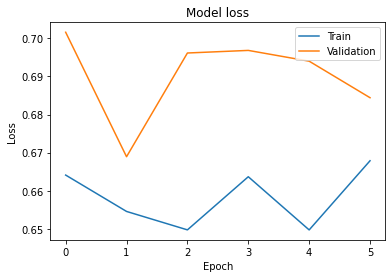

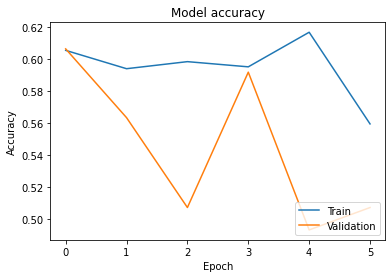

In [10]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training and validation accuracy
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [11]:
model = tf.keras.models.load_model('EfficientViT_3')

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

# Custom preprocessing function for EfficientNet
def efficientnet_preprocessing(x):
    # Apply EfficientNet specific preprocessing
    x = preprocess_input(x)
    return x

# Image Data Generator for training data
train_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

# Image Data Generator for validation data
validation_data_gen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocessing, # Add custom preprocessing
    #rescale=1./255  # Rescaling is still fine here
)

# pre proceess the train images
train_generator = train_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/train/',
    target_size=(224,224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle = False
)

# pre process the test images
validation_generator = validation_data_gen.flow_from_directory(
    '../biometric_project/data/data_50K_2/val/',
    target_size=(224,224),
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    shuffle = False
)

Found 35064 images belonging to 2 classes.
Found 13897 images belonging to 2 classes.


<ipython-input-13-98cda6eb209b>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator)


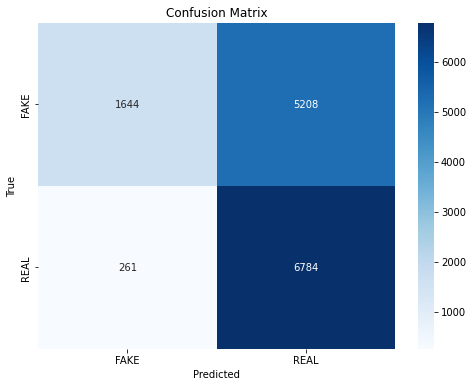

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


predictions = model.predict_generator(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [14]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", accuracy)

Accuracy: 0.6064618262934446


<ipython-input-15-ad5b78e601eb>:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(train_generator)


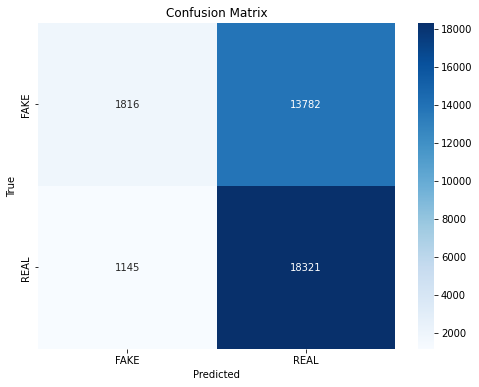

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


predictions = model.predict_generator(train_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = train_generator.classes
class_labels = list(train_generator.class_indices.keys())

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", accuracy)

Accuracy: 0.5742927218799909


In [17]:
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print("Validation Loss:", validation_loss)
print("Validation Accuracy:", validation_accuracy)

435/435 [==============================] - 498s 1s/step - loss: 0.7016 - accuracy: 0.6065
Validation Loss: 0.7015998363494873
Validation Accuracy: 0.6064618229866028


In [18]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples = validation_generator.n 
batch_size = 32

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
#print('Confusion Matrix')
#print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['FAKE','REAL']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

<ipython-input-18-7e620d585617>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator, num_of_test_samples // batch_size+1)


Classification Report
              precision    recall  f1-score   support

        FAKE       0.86      0.24      0.38      6852
        REAL       0.57      0.96      0.71      7045

    accuracy                           0.61     13897
   macro avg       0.71      0.60      0.54     13897
weighted avg       0.71      0.61      0.55     13897



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_train_samples = train_generator.n
batch_size = 32

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(train_generator, num_of_train_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(train_generator.classes, y_pred))
print('Classification Report')
target_names = ['FAKE','REAL']
print(classification_report(train_generator.classes, y_pred, target_names=target_names))


<ipython-input-19-32d1fd546e9f>:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(train_generator, num_of_train_samples // batch_size+1)
